# Binary Classification Using Neural Networks

## Import

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

import torch
import torch.nn as nn
from torch import  optim
from torch.utils.data import DataLoader , TensorDataset
from torchmetrics.classification import Accuracy

## Load and Prepare Data

In [2]:
df_train = pd.read_csv("dataset/train.csv")
df_train.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
1,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
2,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
3,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
4,75.0,1,246,0,15,0,127000.00,1.2,137,1,0,10,1


In [3]:
x = df_train.drop('DEATH_EVENT' , axis=1).values
y = df_train['DEATH_EVENT'].values

x_train , x_valid , y_train , y_valid = train_test_split(x , y , train_size=0.8 , random_state=8)
x_train.shape , x_valid.shape , y_train.shape , y_valid.shape

((199, 12), (50, 12), (199,), (50,))

In [4]:
x_train = torch.FloatTensor(x_train)
x_valid = torch.FloatTensor(x_valid)
y_train = torch.FloatTensor(y_train)
y_valid = torch.FloatTensor(y_valid)


In [5]:
Mean = torch.mean(x_train , dim=0)
std = torch.std(x_train , dim=0)

x_train = (x_train - Mean) / std
x_valid = (x_valid - Mean) / std

In [6]:
train_dataset = TensorDataset(x_train , y_train)
valid_dataset = TensorDataset(x_valid , y_valid)

train_loader = DataLoader(train_dataset , batch_size=4 , shuffle=True)
validation_loader = DataLoader(valid_dataset , batch_size=8)


## Model

In [7]:
in_features = 12
out_features = 1
h1 = 64
h2 = 32


model = nn.Sequential(nn.Linear(in_features , h1)
                      ,nn.ReLU()
                      ,nn.Linear(h1 , h2)
                      ,nn.ReLU()
                      ,nn.Linear(h2 , out_features)
                      ,nn.Sigmoid()
                      )


In [8]:
criterion = nn.BCELoss()

optimizer = optim.SGD(model.parameters() , lr=0.001)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = model.to(device)

##  Train The Model

In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [11]:
train_loss_hist = []
validation_loss_hist = []

train_acc_hist = []
validation_acc_hist = []

In [12]:
N = 500
start_time = time.time()
for epoch in range(N):
    
    loss_train = AverageMeter()
    acc_train = Accuracy(task = 'binary').to(device)
    
    for i , (x_train , y_train) in enumerate(train_loader):
        x_train = x_train.to(device)
        y_train = y_train.to(device)
        y_hat = model(x_train).squeeze()
        loss_value = criterion(y_hat , y_train)
        
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_train.update(loss_value.item(),len(y_train))
        acc_train(y_hat, y_train.int())

    train_loss_hist.append(loss_train.avg)
    train_acc_hist.append(acc_train.compute().cpu())
        
    with torch.no_grad():
        loss_validation = AverageMeter()
        acc_validation = Accuracy(task = 'binary').to(device)
        for i ,(x_valid , y_valid) in enumerate(validation_loader):
            
            x_valid = x_valid.to(device)
            y_valid = y_valid.to(device)
            
            y_hat_valid = model(x_valid).squeeze()
            loss_value = criterion(y_hat_valid , y_valid)
            
            loss_validation.update(loss_value.item() , len(y_valid))
            acc_validation(y_hat_valid , y_valid.int())
        
    validation_loss_hist.append(loss_validation.avg)
    validation_acc_hist.append(acc_validation.compute().cpu())
            
    if epoch % 10 == 0:

        print(f'Epoch: {epoch}')
        print(f'\tTrain Loss: {loss_train.avg:.4f} | Train Accuracy: {acc_train.compute():.4f}')
        print(f'\tValidation Loss: {loss_validation.avg:.4f} | Validation Accuracy: {acc_validation.compute():.4f} \n')

end_time = time.time() - start_time
print(f'Train Time: {end_time:.4f} s')


Epoch: 0
	Train Loss: 0.6820 | Train Accuracy: 0.5578
	Validation Loss: 0.6833 | Validation Accuracy: 0.6200 

Epoch: 10
	Train Loss: 0.6511 | Train Accuracy: 0.6985
	Validation Loss: 0.6644 | Validation Accuracy: 0.6400 

Epoch: 20
	Train Loss: 0.6281 | Train Accuracy: 0.6985
	Validation Loss: 0.6511 | Validation Accuracy: 0.6400 

Epoch: 30
	Train Loss: 0.6093 | Train Accuracy: 0.6985
	Validation Loss: 0.6404 | Validation Accuracy: 0.6400 

Epoch: 40
	Train Loss: 0.5925 | Train Accuracy: 0.6985
	Validation Loss: 0.6306 | Validation Accuracy: 0.6400 

Epoch: 50
	Train Loss: 0.5761 | Train Accuracy: 0.6985
	Validation Loss: 0.6205 | Validation Accuracy: 0.6400 

Epoch: 60
	Train Loss: 0.5595 | Train Accuracy: 0.6985
	Validation Loss: 0.6093 | Validation Accuracy: 0.6600 

Epoch: 70
	Train Loss: 0.5420 | Train Accuracy: 0.7085
	Validation Loss: 0.5968 | Validation Accuracy: 0.6600 

Epoch: 80
	Train Loss: 0.5233 | Train Accuracy: 0.7236
	Validation Loss: 0.5829 | Validation Accuracy: 0.

## Visualize Loss And Accuracy

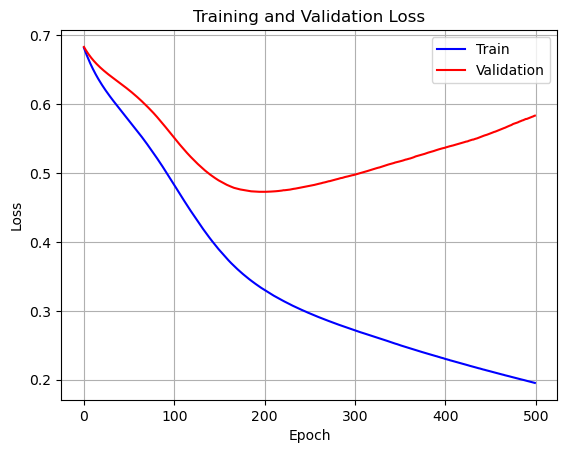

In [13]:
plt.plot(range(N) ,train_loss_hist, 'b-', label="Train")
plt.plot(range(N) ,validation_loss_hist, 'r-', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

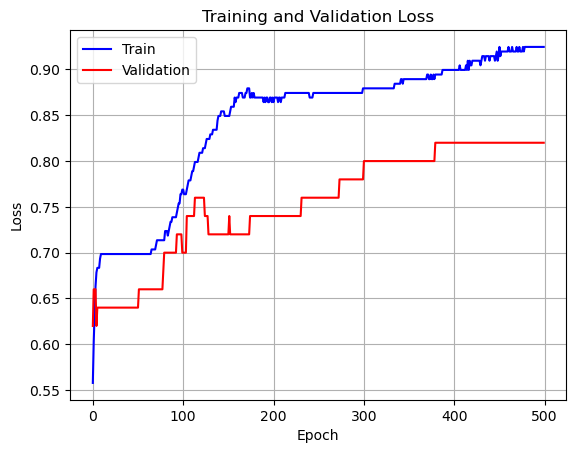

In [14]:
plt.plot(range(N) ,train_acc_hist, 'b-', label="Train")
plt.plot(range(N) ,validation_acc_hist, 'r-', label="Validation")

plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.legend()
plt.show()

## Loading And Testing Model  

In [15]:
df_test = pd.read_csv("dataset/test.csv")
df_test.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time
0,75.0,0,582,0,20,1,265000.0,1.9,130,1,0,4
1,90.0,1,47,0,40,1,204000.0,2.1,132,1,1,8
2,62.0,0,231,0,25,1,253000.0,0.9,140,1,1,10
3,87.0,1,149,0,38,0,262000.0,0.9,140,1,0,14
4,80.0,0,148,1,38,0,149000.0,1.9,144,1,1,23


In [16]:
x_test = df_train.drop('DEATH_EVENT' , axis=1).values
y_test = df_train['DEATH_EVENT'].values

x_test = torch.FloatTensor(x_test)
y_test = torch.FloatTensor(y_test)

x_test = (x_test - Mean) / std

In [17]:
y_test_hat = model(x_test.to(device)).squeeze()
acc = Accuracy(task='binary').to(device)
print(f"Accuracy : {acc(y_test_hat , y_test.to(device))*100:.2f} %")

Accuracy : 90.36 %
